# ACCESS salinity

In [1]:
import intake
import glob
import dask.distributed as dsk
import matplotlib.pyplot as plt
import xarray as xr
import cf_xarray as cfxr
import numpy as np
import xesmf as xe

import cmocean as cm
import cartopy.crs as ccrs

import cartopy.feature as cft
import matplotlib.path as mpath

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
import logging
logging.getLogger("matplotlib").setLevel(logging.WARNING)

In [3]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/36001/status,
Dashboard: /proxy/36001/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37679,Workers: 28
Dashboard: /proxy/36001/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:33105,Total threads: 1
Dashboard: /proxy/35441/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:34061,


2025-09-09 16:57:36,575 - distributed.scheduler - WARNING - Detected different `run_spec` for key ('getitem-ba580fe9a3d0a40d85d5ce688f7d3e48', 2, 3) between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: released
old run_spec: <Task ('getitem-ba580fe9a3d0a40d85d5ce688f7d3e48', 2, 3) getitem(...)>
new run_spec: Alias(('getitem-ba580fe9a3d0a40d85d5ce688f7d3e48', 2, 3)->('concatenate-rechunk-merge-rechunk-split-getitem-ba580fe9a3d0a40d85d5ce688f7d3e48', 2, 3))
old dependencies: {('getitem-d0f75c5e8fe7ac54083fa2a13972d016', 0, 2, 3)}
new dependencies: {('concatenate-rechunk-merge-rechunk-split-getitem-ba580fe9a3d0a40d85d5ce688f7d3e48', 2, 3)}



In [4]:
#Importing data

pathsC = np.sort(glob.glob('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/outpu*/ocean/ocean.nc'))
pathsM = np.sort(glob.glob('/scratch/x77/jn8053/access-om2/archive/01deg_jra55v13_ryf9091_21mbath_sofia_ssp126_prsc_rest/*/ocean/ocean.nc'))

In [5]:
# Shelf mask

def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6_01": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [6]:
depth = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output012/ocean/ocean_grid.nc')['ht']
land_mask = (0 * depth).fillna(1)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom5')

In [7]:
#Time variant variables
def preprocess(ds):
    ds = ds[['salt']].isel(st_ocean=0).sel(yt_ocean=slice(None,-55))
    return ds

cont = xr.open_mfdataset(pathsC, preprocess = preprocess, chunks = 'auto')
melt = xr.open_mfdataset(pathsM, preprocess = preprocess, chunks = 'auto')

In [8]:
#Time slicing
cont = cont.sel(time=slice('1910-01-01','1919-12-31'))
melt = melt.sel(time=slice('1910-01-01','1919-12-31'))

In [9]:
#Time invariant variables
area = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output012/ocean/ocean_grid.nc')['area_t']

In [11]:
# Salinity variable
saltC = cont['salt']
saltM = melt['salt']

In [12]:
# Correcting area
var_C = saltC.isel(time=0)
area_corr = area*(var_C*0 +1)

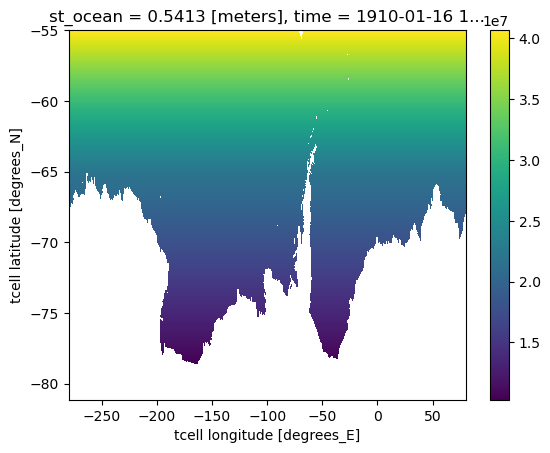

In [13]:
area_corr.plot()

## Surface salinity

In [14]:
shelf_salt_cont = saltC.where(shelf_mask == 1)
shelf_salt_pert = saltM.where(shelf_mask == 1)
shelf_salt_cont

<xarray.DataArray 'salt' (time: 120, yt_ocean: 510, xt_ocean: 3600)> Size: 881MB
dask.array<where, shape=(120, 510, 3600), dtype=float32, chunksize=(2, 146, 360), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -81.11 -81.07 -81.02 ... -59.08 -59.03
  * time      (time) object 960B 1910-01-16 12:00:00 ... 1919-12-16 12:00:00
    st_ocean  float64 8B 0.5413
    geolon_t  (yt_ocean, xt_ocean) float32 7MB nan nan nan ... 79.75 79.85 79.95
    geolat_t  (yt_ocean, xt_ocean) float32 7MB nan nan nan ... -59.03 -59.03
Attributes:
    long_name:      Practical Salinity
    units:          psu
    valid_range:    [-10. 100.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_salinity

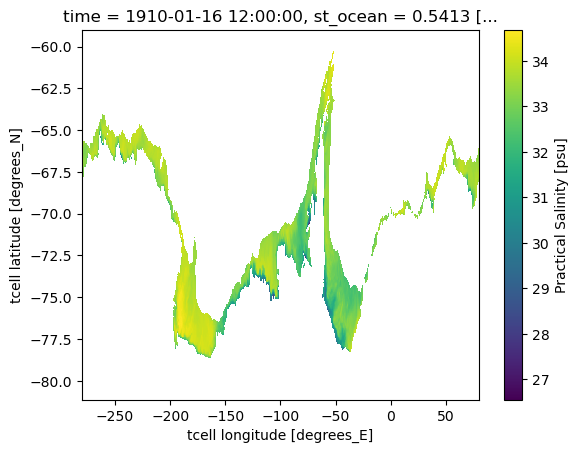

In [15]:
shelf_salt_cont.isel(time=0).plot()

#### time series

In [16]:
# Spatial average
topsalt_cont_time = (area_corr * shelf_salt_cont).sum(['xt_ocean', 'yt_ocean']) / area_corr.where(shelf_mask == 1).sum(['xt_ocean', 'yt_ocean'])
topsalt_pert_time = (area_corr * shelf_salt_pert).sum(['xt_ocean', 'yt_ocean']) / area_corr.where(shelf_mask == 1).sum(['xt_ocean', 'yt_ocean'])

In [17]:
topsalt_cont_time

<xarray.DataArray (time: 120)> Size: 480B
dask.array<truediv, shape=(120,), dtype=float32, chunksize=(2,), chunktype=numpy.ndarray>
Coordinates:
    st_ocean  float64 8B 0.5413
  * time      (time) object 960B 1910-01-16 12:00:00 ... 1919-12-16 12:00:00

In [18]:
topsalt_cont_time = topsalt_cont_time.load()

In [19]:
topsalt_pert_time = topsalt_pert_time.load()

Text(0.5, 1.0, 'ACCESS Time Series of Surface Salinity on Shelf')

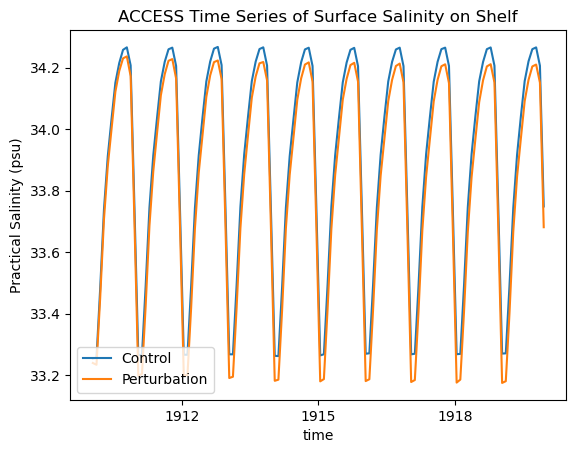

In [20]:
topsalt_cont_time.plot(label="Control")
topsalt_pert_time.plot(label="Perturbation")
#plt.xlim(380,4000)
#plt.ylim(-1.30,-0.70)
plt.ylabel("Practical Salinity (psu)")
plt.legend(loc="lower left")
plt.title("ACCESS Time Series of Surface Salinity on Shelf")

In [21]:
topsalt_anom_time = topsalt_pert_time - topsalt_cont_time
topsalt_anom_time = topsalt_anom_time.load()

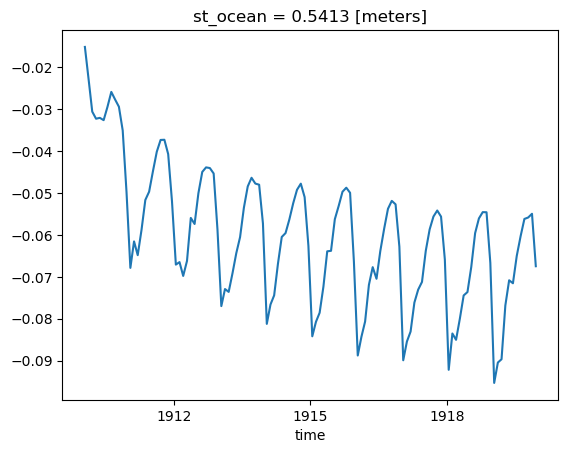

In [22]:
topsalt_anom_time.plot()

In [23]:
topsalt_anom_time.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/topsalt_anom_prescribed_access.nc')

#### Mapping bottom salinity

In [24]:
saltC_map = saltC.sel(time=slice('1915-01-01','1919-12-31'))
saltM_map = saltM.sel(time=slice('1915-01-01','1919-12-31'))

In [25]:
saltC_map

<xarray.DataArray 'salt' (time: 60, yt_ocean: 584, xt_ocean: 3600)> Size: 505MB
dask.array<getitem, shape=(60, 584, 3600), dtype=float32, chunksize=(2, 270, 360), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 5kB -81.11 -81.07 -81.02 ... -55.07 -55.01
    st_ocean  float64 8B 0.5413
  * time      (time) object 480B 1915-01-16 12:00:00 ... 1919-12-16 12:00:00
Attributes:
    long_name:      Practical Salinity
    units:          psu
    valid_range:    [-10. 100.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_salinity

In [26]:
topsalt_cont_map = saltC_map.mean(dim='time')
topsalt_pert_map = saltM_map.mean(dim='time')
topsalt_anom_map = topsalt_pert_map - topsalt_cont_map

In [27]:
topsalt_anom_map

<xarray.DataArray 'salt' (yt_ocean: 584, xt_ocean: 3600)> Size: 8MB
dask.array<sub, shape=(584, 3600), dtype=float32, chunksize=(270, 360), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 5kB -81.11 -81.07 -81.02 ... -55.07 -55.01
    st_ocean  float64 8B 0.5413

In [28]:
topsalt_anom_map = topsalt_anom_map.load()

In [29]:
land_mask = (0 * depth).fillna(1)
land = xr.where(np.isnan(depth.rename('land')), 1, np.nan)
projection = ccrs.SouthPolarStereo()

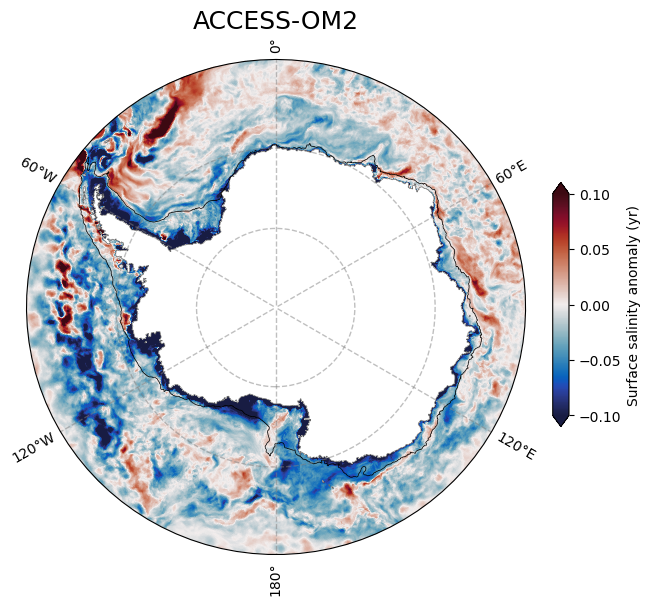

In [30]:
plt.figure(figsize=(7, 8))
ax = plt.axes(projection=projection)
ax.set_extent([-280, 80, -80, -59], crs=ccrs.PlateCarree())
    
# Circular boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5,0.495], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# Filled land 
land.plot.contourf(ax=ax, colors='white',
                   zorder=2,
                   transform=ccrs.PlateCarree(),
                   add_colorbar=False)

# Coast line
ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels = [0, 1], colors = 'dimgrey',linewidths=0.5, transform = ccrs.PlateCarree())
# Shelf contour
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           levels = [0, 1], colors = 'k', linewidths=0.5,transform = ccrs.PlateCarree())

# Adding polar axes
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, 
                    xlocs=range(-180,171,60), ylocs=[], 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, 
                    xlocs=[], ylocs=(-80,-70,-55), 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)

# Plotting
topsalt_anom_map.plot(
    x="xt_ocean",
    y="yt_ocean",
    transform=ccrs.PlateCarree(),
    vmin=-0.1,
    vmax=0.1,
    extend="both",
    cmap=cm.cm.balance, #cm ocean colour maps for more options, matplotlib has more also.
    cbar_kwargs={"label": "Surface salinity anomaly (yr)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);

plt.title("ACCESS-OM2",fontsize=18);

In [31]:
# Create a mask: True where depth is greater (deeper) than 3000m (or less if bathy is negative)
mask_3000m = depth > 3500  # or bathy < -3000 depending on bathy convention (usually negative)

# Mask your data array (abs_anom) where bathy is deeper than 3000m
import numpy as np
topsalt_anom_map_masked = topsalt_anom_map.where(~mask_3000m).fillna(0)  # keep data only shallower or equal to 3000m

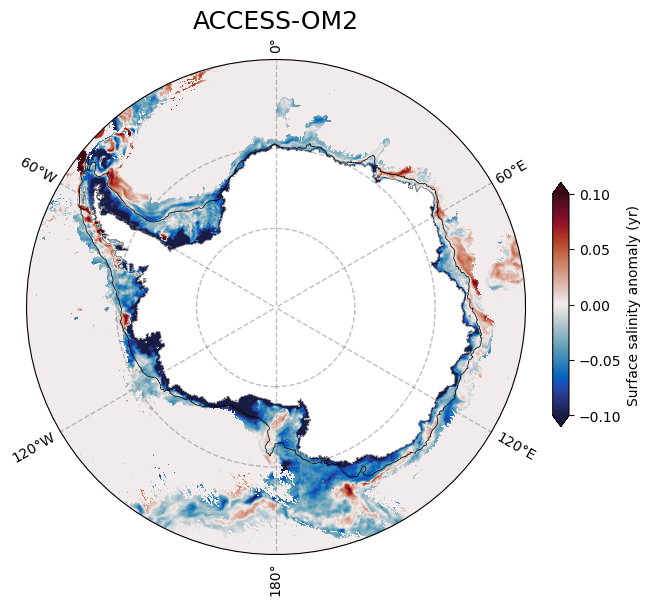

In [32]:
projection = ccrs.SouthPolarStereo()
    
plt.figure(figsize=(7, 8))
ax = plt.axes(projection=projection)
ax.set_extent([-280, 80, -80, -59], crs=ccrs.PlateCarree())
    
# Circular boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5,0.495], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# Filled land 
land.plot.contourf(ax=ax, colors='white',
                   zorder=2,
                   transform=ccrs.PlateCarree(),
                   add_colorbar=False)

# Coast line
ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels = [0, 1], colors = 'dimgrey',linewidths=0.5, transform = ccrs.PlateCarree())
# Shelf contour
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           levels = [0, 1], colors = 'k', linewidths=0.5,transform = ccrs.PlateCarree())

# Adding polar axes
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, 
                    xlocs=range(-180,171,60), ylocs=[], 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, 
                    xlocs=[], ylocs=(-80,-70,-55), 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)

# Plotting
topsalt_anom_map_masked.plot(
    x="xt_ocean",
    y="yt_ocean",
    transform=ccrs.PlateCarree(),
    vmin=-0.1,
    vmax=0.1,
    extend="both",
    cmap=cm.cm.balance, #cm ocean colour maps for more options, matplotlib has more also.
    cbar_kwargs={"label": "Surface salinity anomaly (yr)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);


plt.title("ACCESS-OM2",fontsize=18);